In [14]:
#preliminary setup
%pip install -r requirements.txt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.preprocessing import StandardScaler, MinMaxScaler


#Fetching the data
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# set seeds for reproducibility
random_seed = 302
torch.manual_seed(302); np.random.seed(302)

X, y = fetch_california_housing(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.125, random_state=random_seed)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=random_seed, )

Note: you may need to restart the kernel to use updated packages.


Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        3.86      28.65       5.43        1.1     1421.79        3.13      35.64    -119.58
 std        1.89      12.58       2.41       0.43     1110.97       12.39       2.14       2.01
 min         0.5        1.0       0.85       0.33         6.0        0.69      32.54    -124.35
 max        15.0       52.0     141.91      25.64     35682.0     1243.33      41.95    -114.47


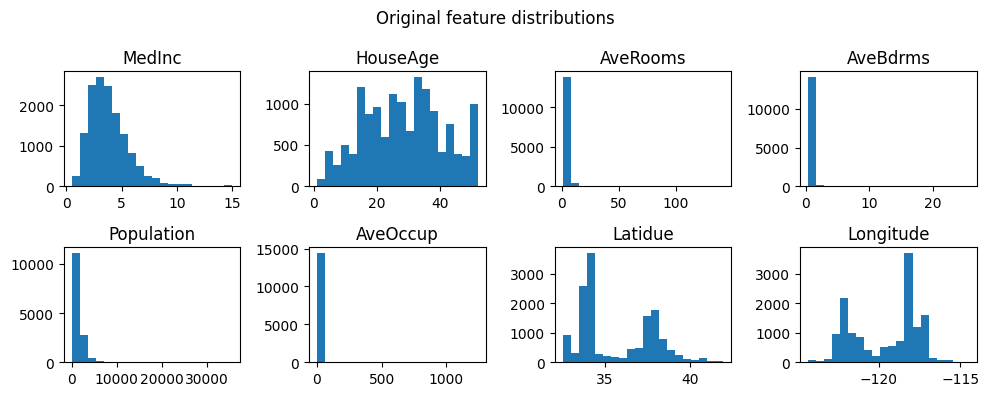

Training set
size: (14448, 8)
          MedInc   HouseAge   AveRooms   AveBdrms   Population   AveOccup   Latidue   Longitude
mean        -0.0       -0.0       -0.0       -0.0        -0.0         0.0        0.0       -0.0
 std         1.0        1.0        1.0        1.0         1.0         1.0        1.0        1.0
 min       -1.78       -2.2       -1.9      -1.76       -1.27        -0.2      -1.45      -2.37
 max         5.9       1.86      56.72      56.66       30.84       100.1       2.95       2.54


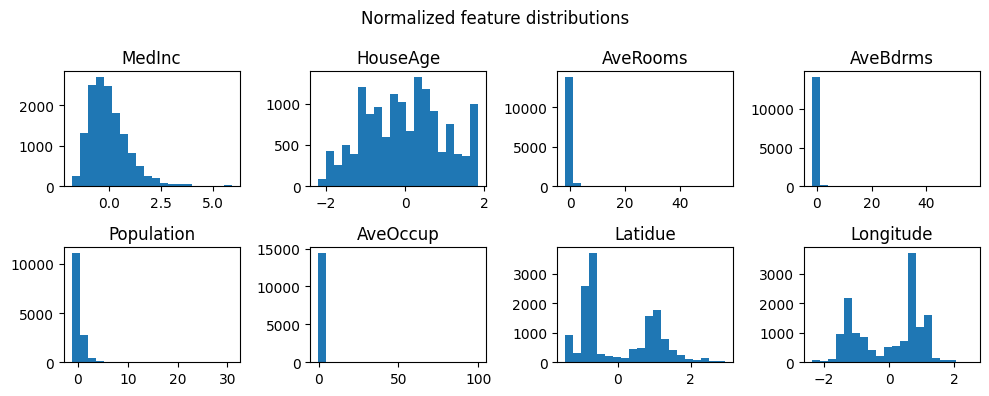

In [15]:
ONLY_TRAINING_SET = True
#a.) Investigating the dataset

all_sets = [X_train,y_train,X_validation,y_validation,X_test,y_test]
all_sets_names = ["Training set","Training targtets","Validation set","Validation targets","Test set","Test targets"]
features = ["MedInc","HouseAge","AveRooms","AveBdrms","Population","AveOccup","Latidue","Longitude"]
if ONLY_TRAINING_SET:
    all_sets = [X_train, y_train]
    all_sets_names = ["Training set","Training targtets"]


#Checking the data, to see what would be good to normalize
for set, name in zip(all_sets[0::2],all_sets_names[0::2]):
    
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
             "std":[],
             "min":[],
             "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))
    
    plt.suptitle("Original feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'feature distributions'}.png")

#Normalizing data

#fitting the scalers first on the training set and then applying same scalings to the validation and test set
normalized_sets = all_sets.copy()
standard_dist_scaler_1 = StandardScaler()
standard_dist_scaler_1.fit(X_train)
X_train_standard = standard_dist_scaler_1.transform(X_train)

min_max_scaler = MinMaxScaler()
min_max_scaler.fit(X_train_standard)
X_train_standart_minmax = min_max_scaler.transform(X_train_standard)

#do another scaling, so it's centered around 0 again
standard_dist_scaler_2 = StandardScaler()
standard_dist_scaler_2.fit(X_train_standart_minmax)

#TODO: Decide normalization on individual level
# now only applied standardization everywhere

for i,set in enumerate(all_sets[0::2]):
    norm_set = standard_dist_scaler_1.transform(set)
    #norm_set = min_max_scaler.transform(norm_set)
    #norm_set = standard_dist_scaler_2.transform(norm_set)
    normalized_sets[i] = norm_set

    # new_set = np.zeros_like(set)
    # for col in range(len(features)):

    #     norm_feature = np.reshape(set[:,col],(1,len(set[:,col])))
        
    #     #Standard gauss distribution
    #     norm_feature = (norm_feature-np.mean(norm_feature))/np.std(norm_feature)
    #     all_sets[i*2][:,col] = norm_feature
        
    #     #min-max scaling into -1 +1 range
    #     norm_feature = (norm_feature-np.min(np.abs(norm_feature)))/(np.max(np.abs(norm_feature))-np.min(np.abs(norm_feature)))
    #     new_set[:,col] = norm_feature

    # normalized_sets.append(new_set)

for i,(set,name) in enumerate(zip(normalized_sets[0::2],all_sets_names[0::2])):
    print('\033[4m'+'\033[1m'+f"{name}"+'\033[0m'+'\033[0m')
    print(f"size: {str(set.shape) : >10}")
    stats = {"mean":[],
                "std":[],
                "min":[],
                "max":[]}
    fig,axs = plt.subplots(2,len(features)//2,figsize=(10,4),layout = "tight")
    for col,feature in enumerate(features):
        feature_data = set[:,col]
        stats["mean"].append(np.mean(feature_data))
        stats["std"].append(np.std(feature_data))
        stats["min"].append(np.min(feature_data))
        stats["max"].append(np.max(feature_data))
        axs[int(np.floor(col/4))][(col%4)].hist(feature_data,bins=20)
        axs[int(np.floor(col/4))][(col%4)].set_title(feature)
        

    print('\033[1m'+"          "+f"{'   '.join(features)}"+'\033[0m')
    for stat,vals in stats.items():
        x = [str(round(val,2)) for val in vals]
        print('{:>4}{:>12s}{:>11s}{:>11s}{:>11s}{:>12s}{:>12s}{:>11s}{:>11s}'.format(stat,x[0],x[1],x[2],x[3],x[4],x[5],x[6],x[7]))

    plt.suptitle("Normalized feature distributions")
    plt.show()
    fig.savefig(f"./plots/{'normalized feature distributions'}.png")


## Networks

In [16]:
from models import NeuralNet_deep, NeuralNet_wide, NeuralNet_default, NeuralNet_deep_wider, NeuralNet_deeper_wide

def train_model(model, train_loader, val_loader, device, optimizer=None, num_epochs=5):
    loss_fn = nn.MSELoss()
    #saves losses on every batch
    train_losses_all = []
    val_losses_all = []
    for epoch in range(num_epochs):
        train_losses_epoch = []
        print('-'*20, f'Epoch {epoch}', '-'*20)
        # Train one epoch
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            if optimizer is not None:
                optimizer.zero_grad()
            predict = model(data)
            loss = loss_fn(predict, target)
            loss.backward()
            if optimizer is not None:
                optimizer.step()

            train_losses_epoch.append(loss.item())
        
        train_loss_epoch_mean =np.mean(train_losses_epoch)
        train_losses_all.append(train_loss_epoch_mean)
        print(f'Average Training Loss for epoch(over all batches) {np.mean(train_losses_epoch)}')
        
        # Evaluate on validation set
        model.eval()
        val_loss = 0
        # correct = 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                predict = model(data)
                val_loss += F.mse_loss(predict, target, reduction='sum').item()  # sum up batch loss
                # correct += (predict == target).sum().item()

        val_loss /= len(val_loader.dataset)
        # avg_correct = correct / len(val_loader.dataset)
        val_losses_all.append(val_loss)
        # val_accuracies.append(avg_correct)

        print(f'Validation loss for epoch: {val_loss:.4f})\n')
    
    return train_losses_all, val_losses_all


NeuralNet_deep
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 308.88100143027515
Validation loss for epoch: 316.8078)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 308.7885398527162
Validation loss for epoch: 316.8078)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 308.78168831884335
Validation loss for epoch: 316.8078)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 308.87692429534104
Validation loss for epoch: 316.8078)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 309.0514618189989
Validation loss for epoch: 316.8078)



C:\Users\lhoeb\AppData\Local\Temp\ipykernel_25588\1393897369.py:24: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[0].set_ylim([max(train_loss),max(train_loss)])
C:\Users\lhoeb\AppData\Local\Temp\ipykernel_25588\1393897369.py:30: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[1].set_ylim([max(val_loss),max(val_loss)])


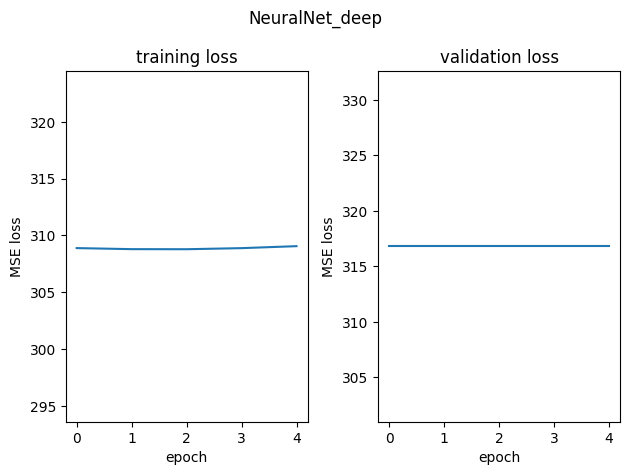

NeuralNet_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 85.15120707148999
Validation loss for epoch: 85.5955)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 85.15661374657554
Validation loss for epoch: 85.5955)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 85.15801019584183
Validation loss for epoch: 85.5955)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 85.16892465236968
Validation loss for epoch: 85.5955)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 85.15419327052294
Validation loss for epoch: 85.5955)



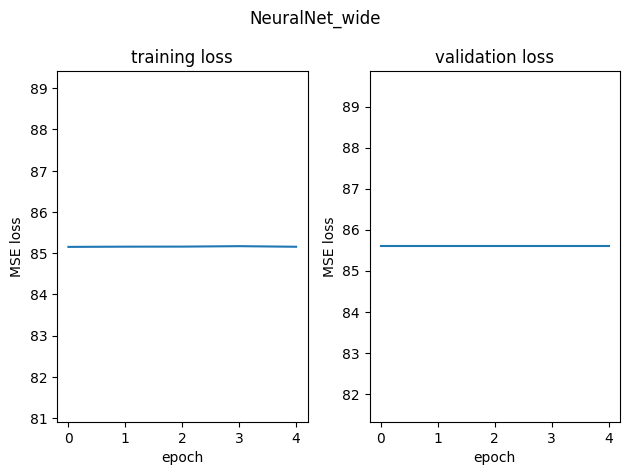

NeuralNet_default
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 625.6992620957636
Validation loss for epoch: 637.9606)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 625.7160795768805
Validation loss for epoch: 637.9606)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 625.7158880993328
Validation loss for epoch: 637.9606)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 625.9469986637082
Validation loss for epoch: 637.9606)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 625.7989919206738
Validation loss for epoch: 637.9606)



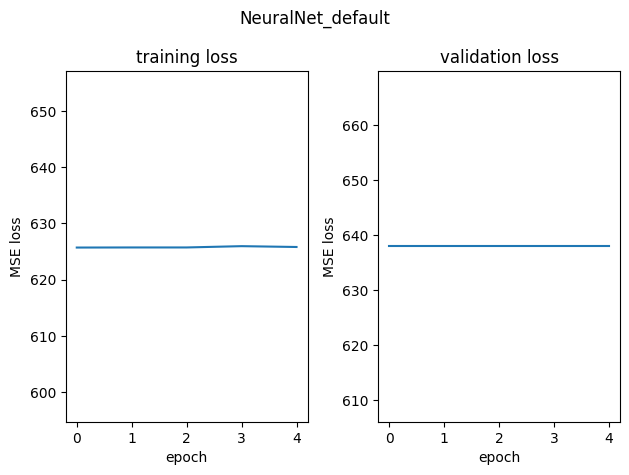

NeuralNet_deep_wider
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 448.2368006073268
Validation loss for epoch: 468.3473)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 448.10490147413407
Validation loss for epoch: 468.3473)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 448.1148405497053
Validation loss for epoch: 468.3473)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 448.15063976186565
Validation loss for epoch: 468.3473)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 448.3591819020499
Validation loss for epoch: 468.3473)



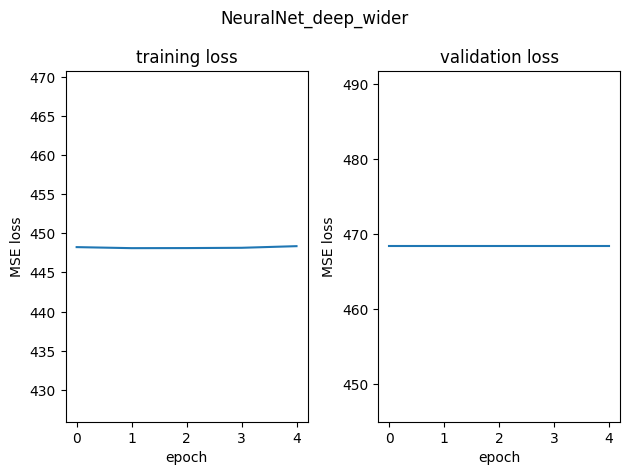

NeuralNet_deeper_wide
-------------------- Epoch 0 --------------------
Average Training Loss for epoch(over all batches) 48.00851249694824
Validation loss for epoch: 50.6357)

-------------------- Epoch 1 --------------------
Average Training Loss for epoch(over all batches) 47.99274906647944
Validation loss for epoch: 50.6357)

-------------------- Epoch 2 --------------------
Average Training Loss for epoch(over all batches) 48.02111539587511
Validation loss for epoch: 50.6357)

-------------------- Epoch 3 --------------------
Average Training Loss for epoch(over all batches) 47.97466007165149
Validation loss for epoch: 50.6357)

-------------------- Epoch 4 --------------------
Average Training Loss for epoch(over all batches) 47.98094608931415
Validation loss for epoch: 50.6357)



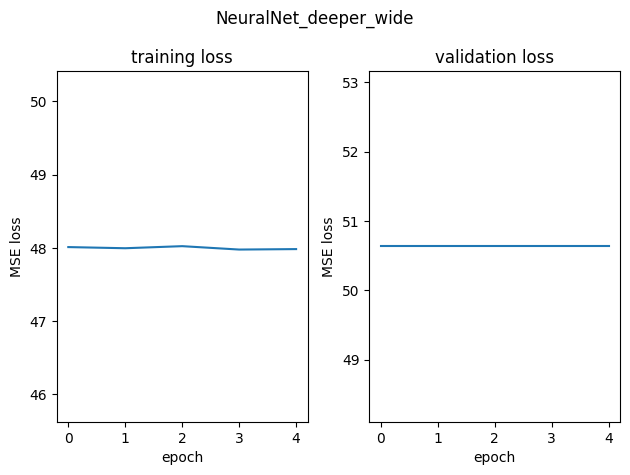

In [21]:
#evaluation of the different models
X_train_torch = torch.tensor(X_train,dtype=torch.float32)
y_train_torch = torch.tensor(y_train.reshape((len(y_train),1)),dtype=torch.float32)
X_validation_torch = torch.tensor(X_validation,dtype=torch.float32)
y_validation_torch = torch.tensor(y_validation.reshape((len(y_validation),1)),dtype=torch.float32)

train_dataset = torch.utils.data.TensorDataset(X_train_torch,y_train_torch)
validation_dataset = torch.utils.data.TensorDataset(X_validation_torch,y_validation_torch)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu' # if you have a gpu, you can move the model onto it like this

all_models = NeuralNet_deep(), NeuralNet_wide(), NeuralNet_default(), NeuralNet_deep_wider(), NeuralNet_deeper_wide()

for model in all_models:
    print(model._get_name())
    train_loss, val_loss = train_model(model,train_loader,val_loader,device)

    fig,axs = plt.subplots(1,2,layout="tight")
    axs[0].plot(train_loss)
    axs[0].set_title("training loss")
    axs[0].set_ylim([max(train_loss),max(train_loss)])
    axs[0].set_xlabel("epoch")
    axs[0].set_ylabel("MSE loss")
    
    axs[1].plot(val_loss)
    axs[1].set_title("validation loss")
    axs[1].set_ylim([max(val_loss),max(val_loss)])
    axs[1].set_xlabel("epoch")
    axs[1].set_ylabel("MSE loss")
    plt.suptitle(f"{model._get_name()}")
    plt.show()